In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 127.5 - 1.
x_train = x_train.reshape(-1, 28*28)  

In [20]:
def build_generator(z_dim):
    model = models.Sequential()

    model.add(layers.Dense(256, input_dim=z_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(28 * 28, activation='tanh'))

    return model

In [21]:
def build_discriminator(img_shape=(28*28,)):
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1, activation='sigmoid')) 
    return model

In [22]:
z_dim = 100

generator = build_generator(z_dim)
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(0.0001, 0.5),
                      metrics=['accuracy'])

discriminator.trainable = False

z = layers.Input(shape=(z_dim,))
img = generator(z)
valid = discriminator(img)

gan = models.Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0001, 0.5))

In [ ]:
def train_gan(epochs, batch_size=128, sample_interval=1000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        z_noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z_noise,verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss = np.clip(d_loss, -1, 1)

        z_noise = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = gan.train_on_batch(z_noise, real)

        if epoch % 2 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch)

In [23]:
def sample_images(epoch, dim=(5,5)):
    z_noise = np.random.normal(0,1,(dim[0]*dim[1], z_dim))
    gen_imgs = generator.predict(z_noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  

    fig, axs = plt.subplots(dim[0], dim[1], figsize=(5,5))
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i,j].imshow(gen_imgs[cnt].reshape(28,28), cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

c:\Users\Bluepal\anaconda3\envs\python_course\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 1.1442, acc.: 23.63%] [G loss: 0.7558]


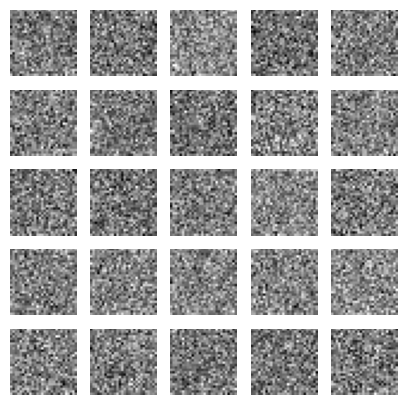

1000 [D loss: 3.2616, acc.: 0.73%] [G loss: 0.0286]


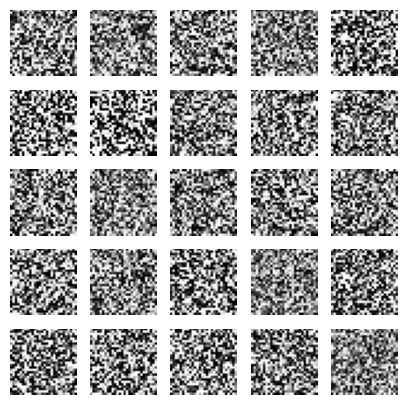

2000 [D loss: 3.7717, acc.: 0.62%] [G loss: 0.0147]


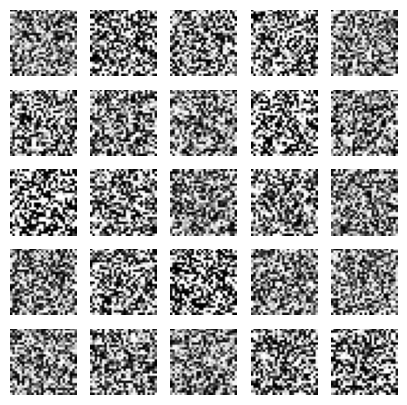

3000 [D loss: 4.0763, acc.: 0.57%] [G loss: 0.0099]


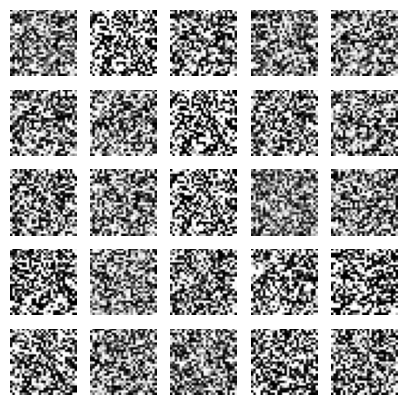

4000 [D loss: 4.3032, acc.: 0.55%] [G loss: 0.0075]


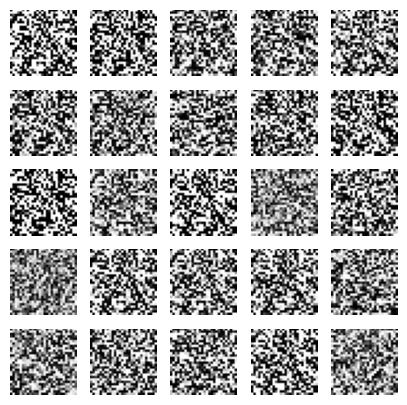

5000 [D loss: 4.4902, acc.: 0.53%] [G loss: 0.0060]


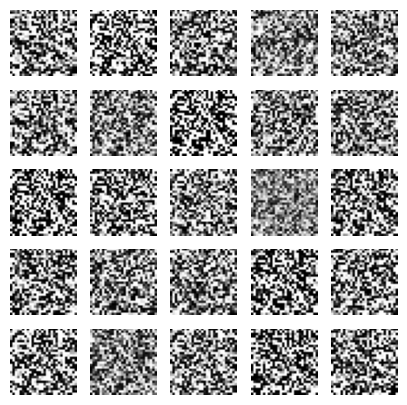

6000 [D loss: 4.6536, acc.: 0.52%] [G loss: 0.0050]


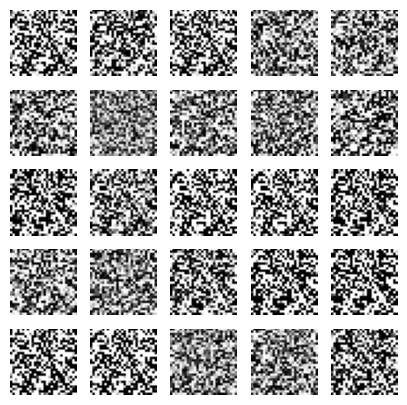

7000 [D loss: 4.8009, acc.: 0.52%] [G loss: 0.0043]


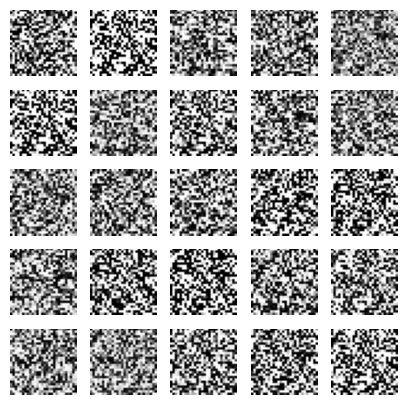

8000 [D loss: 4.9359, acc.: 0.51%] [G loss: 0.0038]


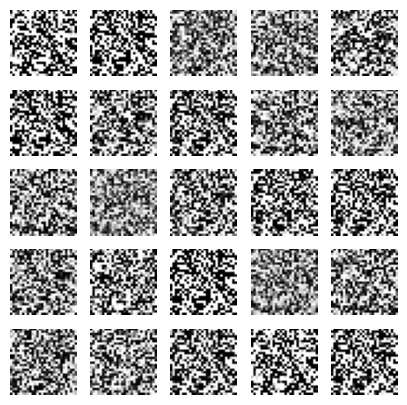

9000 [D loss: 5.0606, acc.: 0.51%] [G loss: 0.0034]


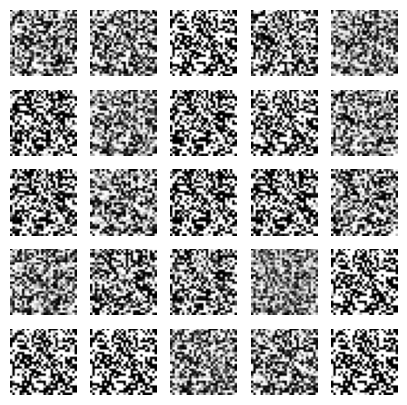

In [24]:
train_gan(epochs=10000, batch_size=128, sample_interval=1000)